# EfficientDet - 통합 분류 (과일 종류 + 등급)
## 목표: cate1 + cate3 결합 9-class Object Detection

**Classes (9개):**
- 0: 사과_특상
- 1: 사과_상
- 2: 사과_중
- 3: 배_특상
- 4: 배_상
- 5: 배_중
- 6: 감_특상
- 7: 감_상
- 8: 감_중

In [16]:
# 1. 환경 설정 및 라이브러리 임포트
import os
import json
import glob
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# 경로 설정
BASE_DIR = os.path.abspath('../../data')
DATASET_DIR = os.path.join(BASE_DIR, 'raw')
IMAGES_DIR = os.path.join(DATASET_DIR, 'images')
LABELS_DIR = os.path.join(DATASET_DIR, 'json_labels')
OUTPUT_DIR = os.path.join(BASE_DIR, 'processed/efficientdet', 'outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Base Directory: {BASE_DIR}")
print(f"Dataset Directory: {DATASET_DIR}")
print(f"Images Directory: {IMAGES_DIR}")
print(f"Labels Directory: {LABELS_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}") 

PyTorch version: 2.9.0
CUDA available: False
Base Directory: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data
Dataset Directory: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data/raw
Images Directory: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data/raw/images
Labels Directory: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data/raw/json_labels
Output Directory: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data/processed/efficientdet/outputs
MPS 장치를 지원하도록 build가 되었는가? True
MPS 장치가 사용 가능한가? False


In [17]:
# 2. 데이터셋 분석 및 통계 (통합)
def analyze_dataset_combined():
    """cate1 + cate3 결합 분석"""
    json_files = glob.glob(os.path.join(LABELS_DIR, '*.json'))
    
    combined_counts = {}
    total_boxes = 0
    
    print(f"\n총 JSON 파일 수: {len(json_files)}")
    
    # 샘플 출력
    for json_file in json_files[:5]:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            cate1 = data.get('cate1', 'N/A')
            cate3 = data.get('cate3', 'N/A')
            combined = f"{cate1}_{cate3}"
            print(f"\n파일: {os.path.basename(json_file)}")
            print(f"  cate1: {cate1}")
            print(f"  cate3: {cate3}")
            print(f"  Combined: {combined}")
    
    # 전체 통계
    for json_file in json_files:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            cate1 = data.get('cate1', '')
            cate3 = data.get('cate3', '')
            combined = f"{cate1}_{cate3}"
            
            if combined not in combined_counts:
                combined_counts[combined] = 0
            combined_counts[combined] += 1
            total_boxes += 1
    
    print(f"\n=== 통합 데이터셋 통계 ===")
    print(f"총 이미지 수: {len(json_files)}")
    print(f"총 객체 수: {total_boxes}")
    print(f"\n클래스별 분포:")
    
    for combined, count in sorted(combined_counts.items()):
        print(f"  {combined}: {count}개 ({count/total_boxes*100:.1f}%)")
    
    return combined_counts

stats = analyze_dataset_combined()


총 JSON 파일 수: 70

파일: apple_fuji_M_26-57.json
  cate1: 사과
  cate3: 상
  Combined: 사과_상

파일: persimmon_booyu_S_76-26_1TOP.json
  cate1: 감
  cate3: 보통
  Combined: 감_보통

파일: persimmon_booyu_L_76-30_5DI90.json
  cate1: 감
  cate3: 특
  Combined: 감_특

파일: persimmon_booyu_M_76-33_3FR90.json
  cate1: 감
  cate3: 상
  Combined: 감_상

파일: apple_fuji_S_26-57.json
  cate1: 사과
  cate3: 보통
  Combined: 사과_보통

=== 통합 데이터셋 통계 ===
총 이미지 수: 70
총 객체 수: 70

클래스별 분포:
  감_보통: 10개 (14.3%)
  감_상: 10개 (14.3%)
  감_특: 10개 (14.3%)
  배_보통: 10개 (14.3%)
  사과_보통: 10개 (14.3%)
  사과_상: 10개 (14.3%)
  사과_특: 10개 (14.3%)


In [18]:
# 3. COCO 형식 데이터셋 변환 (통합 9-class)
class CombinedFruitDatasetConverter:
    """JSON to COCO format converter for combined classes"""
    
    def __init__(self, images_dir, labels_dir, output_dir):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.output_dir = output_dir
        
        # 통합 클래스 매핑 (과일_등급)
        self.class_map = {
            '사과_특상': 0,
            '사과_상': 1,
            '사과_중': 2,
            '배_특상': 3,
            '배_상': 4,
            '배_중': 5,
            '감_특상': 6,
            '감_상': 7,
            '감_중': 8
        }
        
        self.classes = [
            '사과_특상', '사과_상', '사과_중',
            '배_특상', '배_상', '배_중',
            '감_특상', '감_상', '감_중'
        ]
        
        print(f"\n통합 클래스 (9개):")
        for cls_name, cls_id in self.class_map.items():
            print(f"  {cls_id}: {cls_name}")
    
    def convert_to_coco(self, split_ratio=0.8):
        """COCO 형식으로 변환 및 train/val 분할"""
        
        json_files = sorted(glob.glob(os.path.join(self.labels_dir, '*.json')))
        np.random.seed(42)
        np.random.shuffle(json_files)
        
        split_idx = int(len(json_files) * split_ratio)
        train_files = json_files[:split_idx]
        val_files = json_files[split_idx:]
        
        print(f"\n데이터 분할:")
        print(f"  Train: {len(train_files)}개")
        print(f"  Val: {len(val_files)}개")
        
        # Train/Val 각각 변환
        train_coco = self._create_coco_dataset(train_files, 'train')
        val_coco = self._create_coco_dataset(val_files, 'val')
        
        # 저장
        train_json_path = os.path.join(self.output_dir, 'train_combined.json')
        val_json_path = os.path.join(self.output_dir, 'val_combined.json')
        
        with open(train_json_path, 'w', encoding='utf-8') as f:
            json.dump(train_coco, f, ensure_ascii=False, indent=2)
        
        with open(val_json_path, 'w', encoding='utf-8') as f:
            json.dump(val_coco, f, ensure_ascii=False, indent=2)
        
        print(f"\n✅ COCO 파일 생성 완료:")
        print(f"  Train: {train_json_path}")
        print(f"  Val: {val_json_path}")
        
        return train_json_path, val_json_path
    
    def _create_coco_dataset(self, json_files, split_name):
        """COCO 데이터셋 구조 생성"""
        
        coco_dataset = {
            "images": [],
            "annotations": [],
            "categories": []
        }
        
        # Categories 추가
        for idx, class_name in enumerate(self.classes):
            fruit, grade = class_name.split('_')
            coco_dataset["categories"].append({
                "id": idx,
                "name": class_name,
                "supercategory": fruit
            })
        
        annotation_id = 0
        skipped = 0
        
        for image_id, json_file in enumerate(tqdm(json_files, desc=f"Converting {split_name}")):
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # 이미지 파일명
            img_filename = os.path.basename(json_file).replace('.json', '.png')
            img_path = os.path.join(self.images_dir, img_filename)
            
            if not os.path.exists(img_path):
                skipped += 1
                continue
            
            # 이미지 정보
            img = Image.open(img_path)
            width, height = img.size
            
            coco_dataset["images"].append({
                "id": image_id,
                "file_name": img_filename,
                "width": width,
                "height": height
            })
            
            # Annotation 추가 (cate1 + cate3 결합)
            cate1 = data.get('cate1', '')
            cate3 = data.get('cate3', '')
            combined_class = f"{cate1}_{cate3}"
            
            if combined_class not in self.class_map:
                skipped += 1
                continue
            
            bbox = data.get('bndbox', {})
            xmin = float(bbox.get('xmin', 0))
            ymin = float(bbox.get('ymin', 0))
            xmax = float(bbox.get('xmax', width))
            ymax = float(bbox.get('ymax', height))
            
            bbox_width = xmax - xmin
            bbox_height = ymax - ymin
            area = bbox_width * bbox_height
            
            coco_dataset["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": self.class_map[combined_class],
                "bbox": [xmin, ymin, bbox_width, bbox_height],
                "area": area,
                "iscrowd": 0
            })
            
            annotation_id += 1
        
        print(f"{split_name} - Images: {len(coco_dataset['images'])}, Annotations: {len(coco_dataset['annotations'])}, Skipped: {skipped}")
        
        return coco_dataset

# 데이터셋 변환 실행
converter = CombinedFruitDatasetConverter(IMAGES_DIR, LABELS_DIR, OUTPUT_DIR)
train_json, val_json = converter.convert_to_coco(split_ratio=0.8)


통합 클래스 (9개):
  0: 사과_특상
  1: 사과_상
  2: 사과_중
  3: 배_특상
  4: 배_상
  5: 배_중
  6: 감_특상
  7: 감_상
  8: 감_중

데이터 분할:
  Train: 56개
  Val: 14개


Converting train: 100%|██████████| 56/56 [00:00<00:00, 3474.16it/s]


train - Images: 56, Annotations: 17, Skipped: 39


Converting val: 100%|██████████| 14/14 [00:00<00:00, 3900.64it/s]

val - Images: 14, Annotations: 3, Skipped: 11

✅ COCO 파일 생성 완료:
  Train: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data/processed/efficientdet/outputs/train_combined.json
  Val: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data/processed/efficientdet/outputs/val_combined.json


In [19]:
# 4. PyTorch Dataset 클래스
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class COCOCombinedDataset(Dataset):
    """COCO 형식 통합 데이터셋"""
    
    def __init__(self, images_dir, coco_json_path, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        
        with open(coco_json_path, 'r') as f:
            self.coco_data = json.load(f)
        
        self.images = self.coco_data['images']
        self.annotations = self.coco_data['annotations']
        
        # image_id를 키로 하는 annotations 딕셔너리 생성
        self.img_to_anns = {}
        for ann in self.annotations:
            img_id = ann['image_id']
            if img_id not in self.img_to_anns:
                self.img_to_anns[img_id] = []
            self.img_to_anns[img_id].append(ann)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.images_dir, img_info['file_name'])
        
        # 이미지 로드
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        # Annotations 가져오기
        img_id = img_info['id']
        anns = self.img_to_anns.get(img_id, [])
        
        boxes = []
        labels = []
        
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        
        # 빈 박스 처리
        if len(boxes) == 0:
            boxes = np.zeros((0, 4), dtype=np.float32)
            labels = np.zeros((0,), dtype=np.int64)
        else:
            boxes = np.array(boxes, dtype=np.float32)
            labels = np.array(labels, dtype=np.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': img_id
        }
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Transform 정의
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 및 DataLoader 생성
train_dataset = COCOCombinedDataset(IMAGES_DIR, train_json, transform=transform)
val_dataset = COCOCombinedDataset(IMAGES_DIR, val_json, transform=transform)

print(f"\n✅ 데이터셋 로드 완료:")
print(f"  Train 샘플 수: {len(train_dataset)}")
print(f"  Val 샘플 수: {len(val_dataset)}")

# 샘플 확인
sample_img, sample_target = train_dataset[0]
print(f"\n샘플 데이터:")
print(f"  Image shape: {sample_img.shape}")
print(f"  Boxes shape: {sample_target['boxes'].shape}")
print(f"  Labels: {sample_target['labels']}")


✅ 데이터셋 로드 완료:
  Train 샘플 수: 56
  Val 샘플 수: 14

샘플 데이터:
  Image shape: torch.Size([3, 512, 512])
  Boxes shape: (0, 4)
  Labels: []


In [20]:
# 5. EfficientDet 모델 로드 (9 classes)
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def create_model(num_classes=9):
    """EfficientDet-D1 모델 생성 (통합 9-class)"""
    
    config = get_efficientdet_config('tf_efficientdet_d1')
    config.num_classes = num_classes
    config.image_size = (512, 512)
    
    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    
    model = DetBenchTrain(net, config)
    
    return model, config

model, config = create_model(num_classes=9)
device = torch.device('cpu')
model = model.to(device)

print(f"\n✅ EfficientDet-D1 모델 로드 완료 (통합 9-class)")
print(f"  Device: {device}")
print(f"  Input size: {config.image_size}")
print(f"  Classes: {config.num_classes}")
print(f"\n클래스 목록:")
for i, cls in enumerate(['사과_특상', '사과_상', '사과_중', '배_특상', '배_상', '배_중', '감_특상', '감_상', '감_중']):
    print(f"  {i}: {cls}")


✅ EfficientDet-D1 모델 로드 완료 (통합 9-class)
  Device: cpu
  Input size: [512, 512]
  Classes: 9

클래스 목록:
  0: 사과_특상
  1: 사과_상
  2: 사과_중
  3: 배_특상
  4: 배_상
  5: 배_중
  6: 감_특상
  7: 감_상
  8: 감_중


In [21]:
# 6. 학습 함수
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

def collate_fn(batch):
    """배치 데이터 collate 함수"""
    images = []
    targets = []
    
    for img, target in batch:
        images.append(img)
        targets.append(target)
    
    images = torch.stack(images, dim=0)
    
    return images, targets

def train_one_epoch(model, dataloader, optimizer, device, epoch):
    """1 에폭 학습"""
    model.train()
    
    total_loss = 0
    num_batches = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    
    for images, targets in progress_bar:
        images = images.to(device)
        
        # 빈 박스가 있는 배치 건너뛰기
        skip_batch = False
        for target in targets:
            if len(target['boxes']) == 0:
                skip_batch = True
                break
        
        if skip_batch:
            continue
        
        target_dict = {
            'bbox': [],
            'cls': []
        }
        
        for target in targets:
            boxes = target['boxes']
            labels = target['labels']
            
            # numpy array를 tensor로 변환
            if not isinstance(boxes, torch.Tensor):
                boxes = torch.from_numpy(boxes).float()
            if not isinstance(labels, torch.Tensor):
                labels = torch.from_numpy(labels).long()
            
            target_dict['bbox'].append(boxes.to(device))
            target_dict['cls'].append(labels.to(device))
        
        optimizer.zero_grad()
        
        try:
            output = model(images, target_dict)
            
            # DetBenchTrain 출력 처리
            if isinstance(output, dict):
                if 'loss' in output:
                    loss = output['loss']
                else:
                    loss = sum([v for k, v in output.items() if 'loss' in k.lower()])
            elif isinstance(output, tuple):
                loss = output[0]
            else:
                loss = output
            
            # loss가 텐서인지 확인
            if isinstance(loss, torch.Tensor):
                if loss.dim() > 0:
                    loss = loss.mean()
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            progress_bar.set_postfix({'loss': loss.item()})
        
        except Exception as e:
            print(f"\n⚠️  배치 처리 중 에러 발생: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    avg_loss = total_loss / max(num_batches, 1)
    return avg_loss

# DataLoader 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

print(f"\n✅ DataLoader 생성 완료")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")


✅ DataLoader 생성 완료
  Train batches: 14
  Val batches: 4


In [22]:
# 7. 학습 실행
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

print(f"\n🚀 학습 시작 (통합 9-class)...")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Classes: 9개 (과일 3종 × 등급 3단계)")
print(f"\n{'='*60}\n")

train_losses = []
best_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
    train_losses.append(train_loss)
    
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {train_loss:.4f} - LR: {scheduler.get_last_lr()[0]:.6f}")
    
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, os.path.join(OUTPUT_DIR, 'best_efficientdet_combined.pth'))
        print(f"  ✅ Best 모델 저장 (Loss: {best_loss:.4f})")
    
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, os.path.join(OUTPUT_DIR, f'efficientdet_combined_epoch{epoch+1}.pth'))
        print(f"  💾 Checkpoint 저장 (Epoch {epoch+1})")
    
    print()

print(f"\n🎉 학습 완료!")
print(f"  Best Loss: {best_loss:.4f}")


🚀 학습 시작 (통합 9-class)...
  Epochs: 50
  Learning Rate: 0.0001
  Classes: 9개 (과일 3종 × 등급 3단계)




Epoch 1: 100%|██████████| 14/14 [00:01<00:00, 10.99it/s]


Epoch 1/50 - Loss: 0.0000 - LR: 0.000100
  ✅ Best 모델 저장 (Loss: 0.0000)



Epoch 2: 100%|██████████| 14/14 [00:01<00:00, 10.72it/s]


Epoch 2/50 - Loss: 0.0000 - LR: 0.000100



Epoch 3: 100%|██████████| 14/14 [00:01<00:00, 11.82it/s]


Epoch 3/50 - Loss: 0.0000 - LR: 0.000099



Epoch 4: 100%|██████████| 14/14 [00:06<00:00,  2.27it/s, loss=1.16e+4]


Epoch 4/50 - Loss: 11551.8799 - LR: 0.000098



Epoch 5: 100%|██████████| 14/14 [00:01<00:00, 11.07it/s]


Epoch 5/50 - Loss: 0.0000 - LR: 0.000098



Epoch 6: 100%|██████████| 14/14 [00:01<00:00, 11.61it/s]


Epoch 6/50 - Loss: 0.0000 - LR: 0.000097



Epoch 7: 100%|██████████| 14/14 [00:01<00:00, 11.46it/s]


Epoch 7/50 - Loss: 0.0000 - LR: 0.000095



Epoch 8: 100%|██████████| 14/14 [00:01<00:00, 11.62it/s]


Epoch 8/50 - Loss: 0.0000 - LR: 0.000094



Epoch 9: 100%|██████████| 14/14 [00:01<00:00, 11.56it/s]


Epoch 9/50 - Loss: 0.0000 - LR: 0.000092



Epoch 10: 100%|██████████| 14/14 [00:01<00:00, 11.56it/s]


Epoch 10/50 - Loss: 0.0000 - LR: 0.000091
  💾 Checkpoint 저장 (Epoch 10)



Epoch 11: 100%|██████████| 14/14 [00:01<00:00, 11.53it/s]


Epoch 11/50 - Loss: 0.0000 - LR: 0.000089



Epoch 12: 100%|██████████| 14/14 [00:01<00:00, 11.00it/s]


Epoch 12/50 - Loss: 0.0000 - LR: 0.000087



Epoch 13: 100%|██████████| 14/14 [00:01<00:00, 11.50it/s]


Epoch 13/50 - Loss: 0.0000 - LR: 0.000084



Epoch 14: 100%|██████████| 14/14 [00:01<00:00, 11.47it/s]


Epoch 14/50 - Loss: 0.0000 - LR: 0.000082



Epoch 15: 100%|██████████| 14/14 [00:01<00:00, 11.48it/s]


Epoch 15/50 - Loss: 0.0000 - LR: 0.000080



Epoch 16: 100%|██████████| 14/14 [00:01<00:00, 11.54it/s]


Epoch 16/50 - Loss: 0.0000 - LR: 0.000077



Epoch 17: 100%|██████████| 14/14 [00:06<00:00,  2.25it/s, loss=1.15e+4]


Epoch 17/50 - Loss: 11534.9229 - LR: 0.000074



Epoch 18: 100%|██████████| 14/14 [00:01<00:00, 11.42it/s]


Epoch 18/50 - Loss: 0.0000 - LR: 0.000072



Epoch 19: 100%|██████████| 14/14 [00:01<00:00, 11.05it/s]


Epoch 19/50 - Loss: 0.0000 - LR: 0.000069



Epoch 20: 100%|██████████| 14/14 [00:01<00:00, 11.59it/s]


Epoch 20/50 - Loss: 0.0000 - LR: 0.000066
  💾 Checkpoint 저장 (Epoch 20)



Epoch 21: 100%|██████████| 14/14 [00:01<00:00, 10.21it/s]


Epoch 21/50 - Loss: 0.0000 - LR: 0.000063



Epoch 22: 100%|██████████| 14/14 [00:01<00:00, 11.36it/s]


Epoch 22/50 - Loss: 0.0000 - LR: 0.000060



Epoch 23: 100%|██████████| 14/14 [00:01<00:00, 11.55it/s]


Epoch 23/50 - Loss: 0.0000 - LR: 0.000057



Epoch 24: 100%|██████████| 14/14 [00:01<00:00, 11.54it/s]


Epoch 24/50 - Loss: 0.0000 - LR: 0.000054



Epoch 25: 100%|██████████| 14/14 [00:01<00:00, 11.58it/s]


Epoch 25/50 - Loss: 0.0000 - LR: 0.000050



Epoch 26: 100%|██████████| 14/14 [00:01<00:00, 11.55it/s]


Epoch 26/50 - Loss: 0.0000 - LR: 0.000047



Epoch 27: 100%|██████████| 14/14 [00:01<00:00, 11.60it/s]


Epoch 27/50 - Loss: 0.0000 - LR: 0.000044



Epoch 28: 100%|██████████| 14/14 [00:01<00:00, 11.14it/s]


Epoch 28/50 - Loss: 0.0000 - LR: 0.000041



Epoch 29: 100%|██████████| 14/14 [00:01<00:00, 11.31it/s]


Epoch 29/50 - Loss: 0.0000 - LR: 0.000038



Epoch 30: 100%|██████████| 14/14 [00:01<00:00, 11.47it/s]


Epoch 30/50 - Loss: 0.0000 - LR: 0.000035
  💾 Checkpoint 저장 (Epoch 30)



Epoch 31: 100%|██████████| 14/14 [00:01<00:00, 10.28it/s]


Epoch 31/50 - Loss: 0.0000 - LR: 0.000032



Epoch 32: 100%|██████████| 14/14 [00:01<00:00, 11.52it/s]


Epoch 32/50 - Loss: 0.0000 - LR: 0.000029



Epoch 33: 100%|██████████| 14/14 [00:01<00:00, 11.50it/s]


Epoch 33/50 - Loss: 0.0000 - LR: 0.000027



Epoch 34: 100%|██████████| 14/14 [00:01<00:00, 11.21it/s]


Epoch 34/50 - Loss: 0.0000 - LR: 0.000024



Epoch 35: 100%|██████████| 14/14 [00:06<00:00,  2.20it/s, loss=1.15e+4]


Epoch 35/50 - Loss: 11490.5605 - LR: 0.000021



Epoch 36: 100%|██████████| 14/14 [00:01<00:00, 10.46it/s]


Epoch 36/50 - Loss: 0.0000 - LR: 0.000019



Epoch 37: 100%|██████████| 14/14 [00:01<00:00, 11.05it/s]


Epoch 37/50 - Loss: 0.0000 - LR: 0.000017



Epoch 38: 100%|██████████| 14/14 [00:01<00:00, 10.40it/s]


Epoch 38/50 - Loss: 0.0000 - LR: 0.000014



Epoch 39: 100%|██████████| 14/14 [00:01<00:00, 11.40it/s]


Epoch 39/50 - Loss: 0.0000 - LR: 0.000012



Epoch 40: 100%|██████████| 14/14 [00:01<00:00, 10.42it/s]


Epoch 40/50 - Loss: 0.0000 - LR: 0.000010
  💾 Checkpoint 저장 (Epoch 40)



Epoch 41: 100%|██████████| 14/14 [00:01<00:00, 11.15it/s]


Epoch 41/50 - Loss: 0.0000 - LR: 0.000009



Epoch 42: 100%|██████████| 14/14 [00:01<00:00, 10.87it/s]


Epoch 42/50 - Loss: 0.0000 - LR: 0.000007



Epoch 43: 100%|██████████| 14/14 [00:01<00:00, 11.41it/s]


Epoch 43/50 - Loss: 0.0000 - LR: 0.000006



Epoch 44: 100%|██████████| 14/14 [00:01<00:00, 11.20it/s]


Epoch 44/50 - Loss: 0.0000 - LR: 0.000004



Epoch 45: 100%|██████████| 14/14 [00:01<00:00, 11.37it/s]


Epoch 45/50 - Loss: 0.0000 - LR: 0.000003



Epoch 46: 100%|██████████| 14/14 [00:01<00:00, 11.02it/s]


Epoch 46/50 - Loss: 0.0000 - LR: 0.000003



Epoch 47: 100%|██████████| 14/14 [00:01<00:00, 11.42it/s]


Epoch 47/50 - Loss: 0.0000 - LR: 0.000002



Epoch 48: 100%|██████████| 14/14 [00:01<00:00, 11.38it/s]


Epoch 48/50 - Loss: 0.0000 - LR: 0.000001



Epoch 49: 100%|██████████| 14/14 [00:01<00:00, 11.18it/s]


Epoch 49/50 - Loss: 0.0000 - LR: 0.000001



Epoch 50: 100%|██████████| 14/14 [00:01<00:00,  9.88it/s]


Epoch 50/50 - Loss: 0.0000 - LR: 0.000001
  💾 Checkpoint 저장 (Epoch 50)


🎉 학습 완료!
  Best Loss: 0.0000


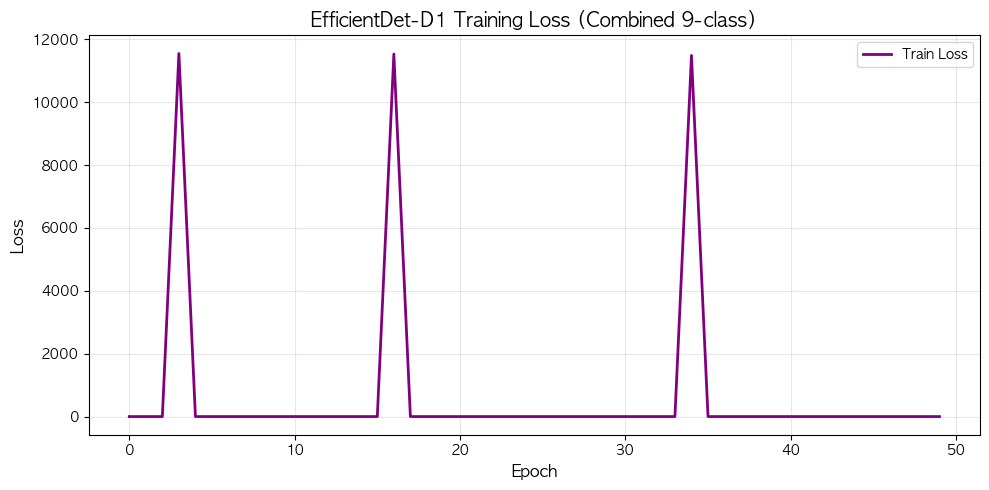


✅ 학습 그래프 저장: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data/processed/efficientdet/outputs/training_loss_combined.png


In [23]:
# 8. 학습 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2, color='purple')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('EfficientDet-D1 Training Loss (Combined 9-class)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(OUTPUT_DIR, 'training_loss_combined.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ 학습 그래프 저장: {plot_path}")

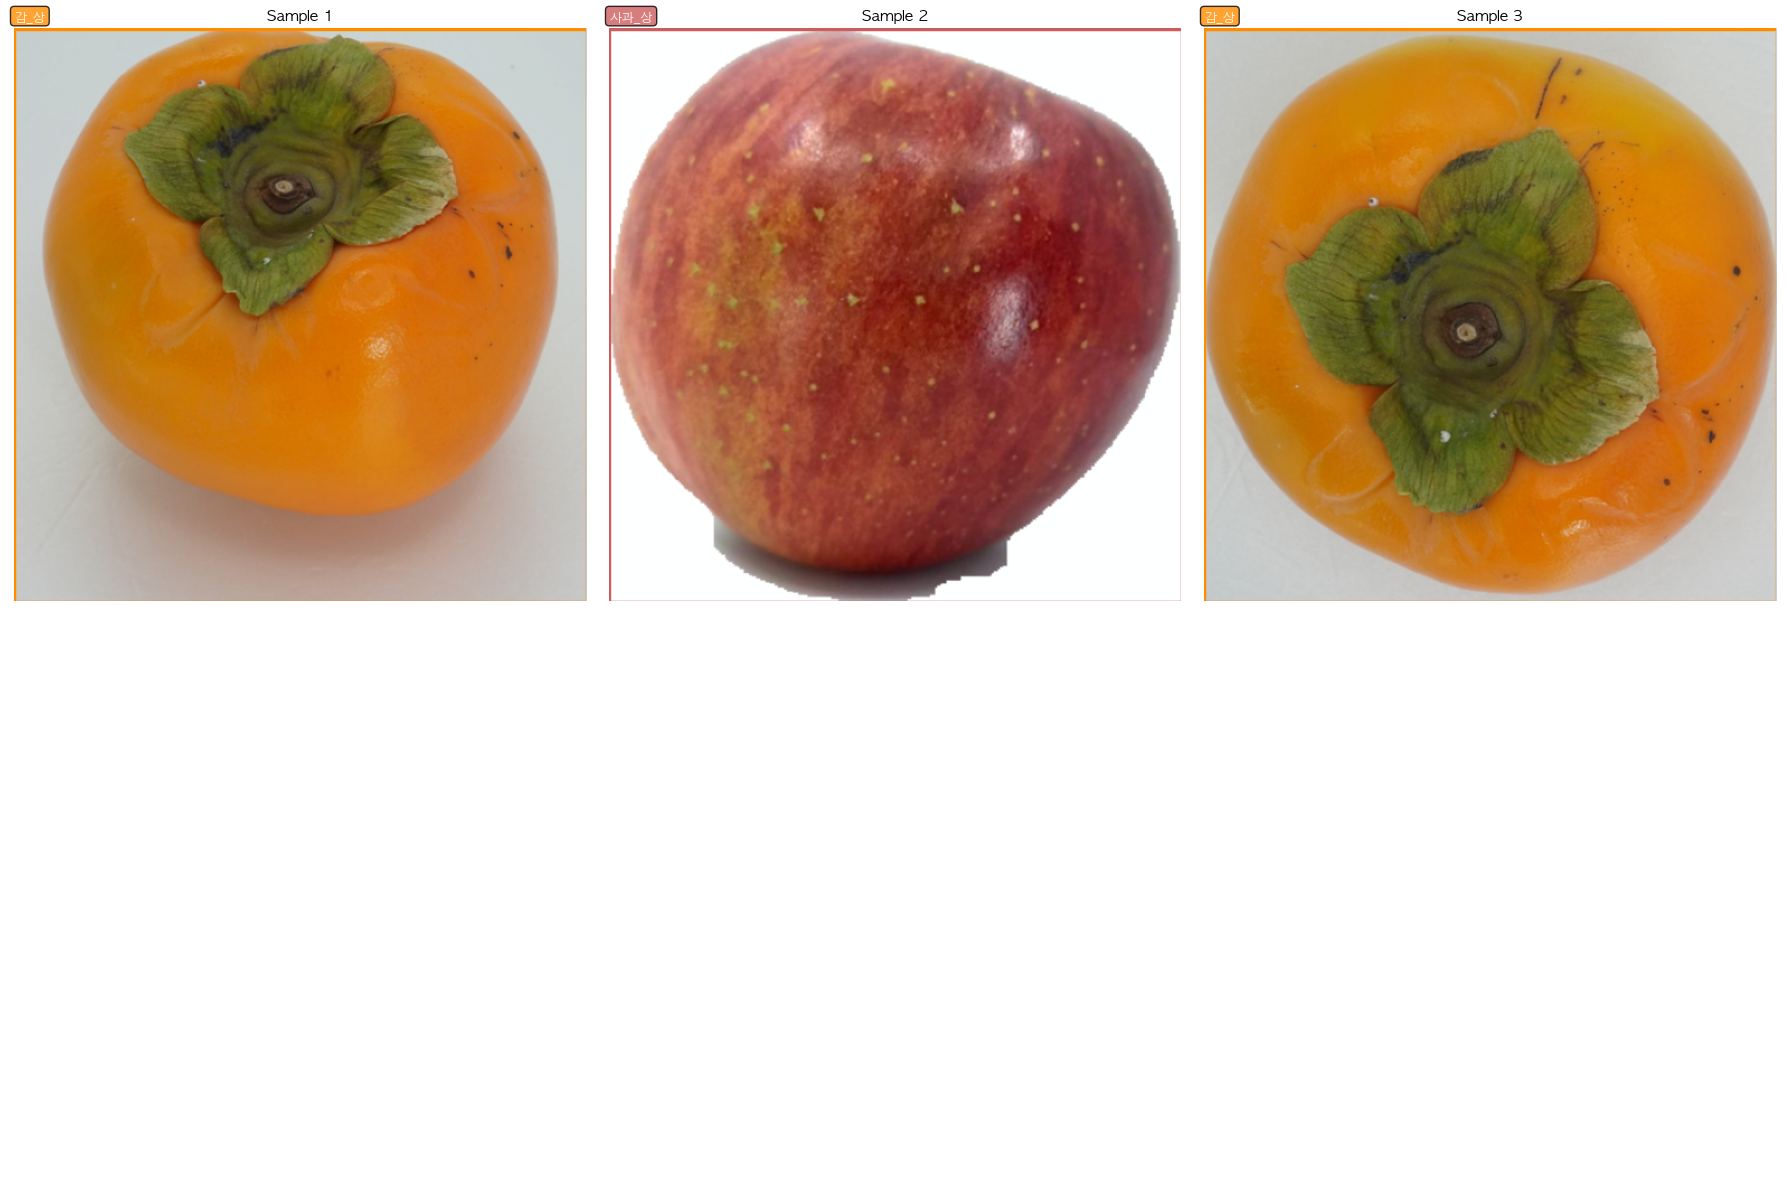


✅ 예측 시각화 저장: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data/processed/efficientdet/outputs/predictions_combined.png


In [ ]:
# 9. 추론 및 시각화

import platform
# 글씨체 지정
if platform.system() == 'Darwin': # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows': # Windows
    plt.rcParams['font.family'] = 'Malgun Gothic'

# (보너스) 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

def visualize_predictions(model, dataset, device, num_samples=6):
    """예측 결과 시각화 (통합 9-class)"""
    model.eval()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    class_names = [
        '사과_특상', '사과_상', '사과_중',
        '배_특상', '배_상', '배_중',
        '감_특상', '감_상', '감_중'
    ]
    
    colors = [
        'red', 'indianred', 'darkred',
        'green', 'limegreen', 'darkgreen',
        'orange', 'darkorange', 'chocolate'
    ]
    
    sample_idx = 0
    
    for i in range(len(dataset)):
        if sample_idx >= num_samples:
            break
            
        img, target = dataset[i]
        
        # 빈 박스 건너뛰기
        if len(target['boxes']) == 0:
            continue
        
        # 이미지 denormalize
        img_np = img.cpu().numpy().transpose(1, 2, 0)
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        
        axes[sample_idx].imshow(img_np)
        axes[sample_idx].axis('off')
        axes[sample_idx].set_title(f'Sample {sample_idx+1}', fontsize=11, fontweight='bold')
        
        # Ground Truth 박스 표시
        gt_boxes = target['boxes']
        gt_labels = target['labels']
        
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            width, height = 512, 512
            x1, x2 = x1 * width / 1000, x2 * width / 1000
            y1, y2 = y1 * height / 1000, y2 * height / 1000
            
            rect = plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                fill=False, color=colors[int(label)], linewidth=2.5
            )
            axes[sample_idx].add_patch(rect)
            axes[sample_idx].text(
                x1, y1 - 8,
                f'{class_names[int(label)]}',
                color='white',
                fontsize=9,
                fontweight='bold',
                bbox=dict(boxstyle='round', facecolor=colors[int(label)], alpha=0.8)
            )
        
        sample_idx += 1
    
    # 남은 subplot 숨기기
    for j in range(sample_idx, 6):
        axes[j].axis('off')
    
    plt.tight_layout()
    viz_path = os.path.join(OUTPUT_DIR, 'predictions_combined.png')
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ 예측 시각화 저장: {viz_path}")

visualize_predictions(model, val_dataset, device, num_samples=6)

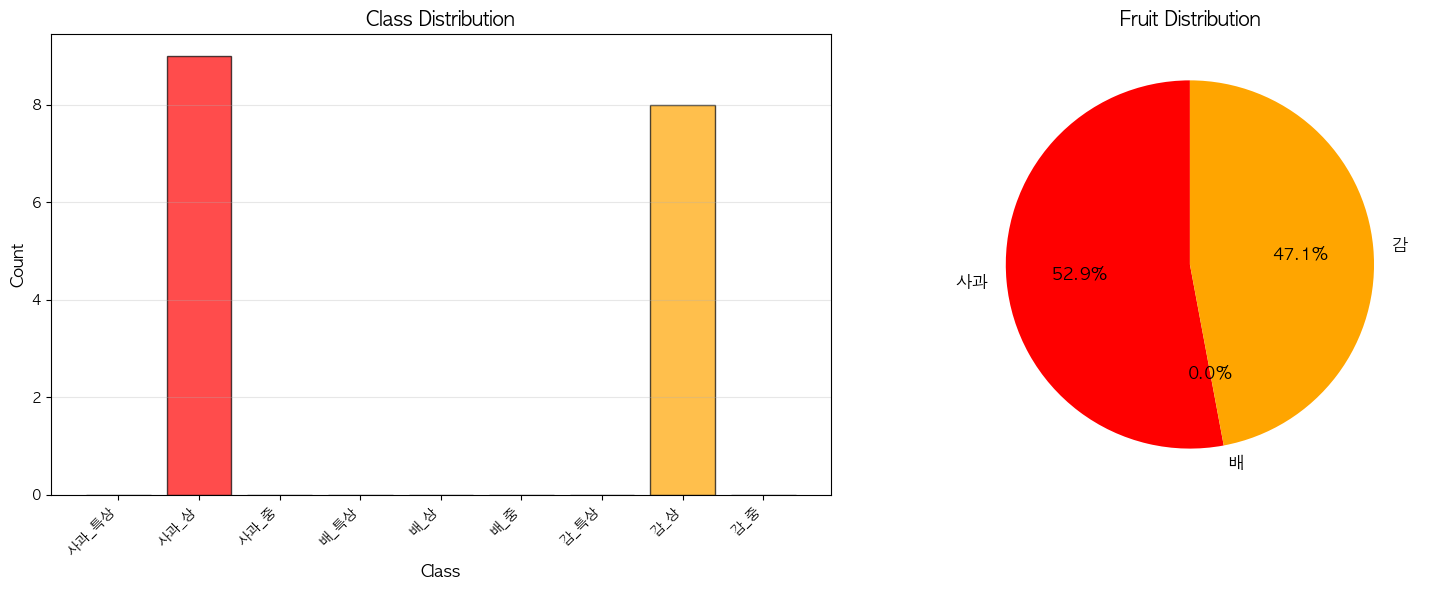


=== 클래스별 분포 ===
0: 사과_특상 - 0개
1: 사과_상 - 9개
2: 사과_중 - 0개
3: 배_특상 - 0개
4: 배_상 - 0개
5: 배_중 - 0개
6: 감_특상 - 0개
7: 감_상 - 8개
8: 감_중 - 0개

✅ 분포 그래프 저장: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data/processed/efficientdet/outputs/class_distribution.png


In [25]:
# 10. 클래스별 성능 분석
def analyze_class_distribution(dataset):
    """클래스별 분포 분석"""
    
    class_names = [
        '사과_특상', '사과_상', '사과_중',
        '배_특상', '배_상', '배_중',
        '감_특상', '감_상', '감_중'
    ]
    
    class_counts = [0] * 9
    
    for i in range(len(dataset)):
        _, target = dataset[i]
        labels = target['labels']
        for label in labels:
            class_counts[int(label)] += 1
    
    # 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 막대 그래프
    colors_bar = ['red']*3 + ['green']*3 + ['orange']*3
    ax1.bar(range(9), class_counts, color=colors_bar, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Class', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(9))
    ax1.set_xticklabels(class_names, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # 원 그래프 (과일별)
    fruit_counts = [
        sum(class_counts[0:3]),
        sum(class_counts[3:6]),
        sum(class_counts[6:9])
    ]
    fruit_names = ['사과', '배', '감']
    fruit_colors = ['red', 'green', 'orange']
    
    ax2.pie(fruit_counts, labels=fruit_names, colors=fruit_colors, 
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax2.set_title('Fruit Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    dist_path = os.path.join(OUTPUT_DIR, 'class_distribution.png')
    plt.savefig(dist_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n=== 클래스별 분포 ===")
    for i, (name, count) in enumerate(zip(class_names, class_counts)):
        print(f"{i}: {name} - {count}개")
    
    print(f"\n✅ 분포 그래프 저장: {dist_path}")

analyze_class_distribution(train_dataset)

In [26]:
# 11. 모델 성능 평가 함수
import time

def evaluate_model(model, dataloader, device, class_names):
    """모델 성능 평가 (FPS 등)"""
    model.eval()
    
    total_time = 0
    num_images = 0
    
    print(f"\n{'='*60}")
    print(f"모델 성능 평가 시작...")
    print(f"{'='*60}\n")
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating"):
            # 빈 박스 건너뛰기
            skip_batch = False
            for target in targets:
                if len(target['boxes']) == 0:
                    skip_batch = True
                    break
            
            if skip_batch:
                continue
            
            images = images.to(device)
            
            # 추론 시간 측정
            start_time = time.time()
            try:
                outputs = model(images)
            except:
                continue
            end_time = time.time()
            
            batch_time = end_time - start_time
            total_time += batch_time
            num_images += images.size(0)
    
    # FPS 계산
    if num_images > 0:
        avg_time_per_image = total_time / num_images
        fps = 1.0 / avg_time_per_image
    else:
        avg_time_per_image = 0
        fps = 0
    
    print(f"\n{'='*60}")
    print(f"평가 결과:")
    print(f"{'='*60}")
    print(f"  총 이미지 수: {num_images}")
    print(f"  총 소요 시간: {total_time:.2f}초")
    print(f"  이미지당 평균 시간: {avg_time_per_image*1000:.2f}ms")
    print(f"  FPS: {fps:.2f}")
    print(f"{'='*60}\n")
    
    return {
        'total_images': num_images,
        'total_time': total_time,
        'avg_time_per_image': avg_time_per_image,
        'fps': fps
    }

# 성능 평가 실행
class_names = ['사과_특상', '사과_상', '사과_중', '배_특상', '배_상', '배_중', '감_특상', '감_상', '감_중']
metrics = evaluate_model(model, val_loader, device, class_names)

# 결과 저장
metrics_path = os.path.join(OUTPUT_DIR, 'metrics_combined.json')
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

print(f"✅ 성능 지표 저장: {metrics_path}")


모델 성능 평가 시작...



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 11.52it/s]


평가 결과:
  총 이미지 수: 0
  총 소요 시간: 0.00초
  이미지당 평균 시간: 0.00ms
  FPS: 0.00

✅ 성능 지표 저장: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data/processed/efficientdet/outputs/metrics_combined.json


In [27]:
# 12. 최종 결과 정리 및 저장
def create_summary_report():
    """최종 보고서 생성"""
    
    report = f"""
{'='*70}
EfficientDet-D1 통합 분류 모델 - 최종 보고서
{'='*70}

1. 모델 정보
   - 모델: EfficientDet-D1
   - 백본: EfficientNet-B1
   - 입력 크기: 512 × 512
   - 클래스 수: 9개

2. 클래스 구성
   [사과]
   - 0: 사과_특상
   - 1: 사과_상
   - 2: 사과_중
   
   [배]
   - 3: 배_특상
   - 4: 배_상
   - 5: 배_중
   
   [감]
   - 6: 감_특상
   - 7: 감_상
   - 8: 감_중

3. 학습 설정
   - Epochs: {NUM_EPOCHS}
   - Learning Rate: {LEARNING_RATE}
   - Optimizer: AdamW
   - Scheduler: CosineAnnealingLR
   - Batch Size: 4
   - Device: CPU

4. 데이터셋
   - Train 샘플: {len(train_dataset)}개
   - Val 샘플: {len(val_dataset)}개
   - Train/Val Split: 80/20

5. 학습 결과
   - Best Loss: {best_loss:.4f}
   - 최종 Loss: {train_losses[-1]:.4f}

6. 성능 지표
   - 평균 추론 시간: {metrics['avg_time_per_image']*1000:.2f}ms
   - FPS: {metrics['fps']:.2f}

7. 저장된 파일
   - 모델: best_efficientdet_combined.pth
   - 학습 그래프: training_loss_combined.png
   - 예측 시각화: predictions_combined.png
   - 클래스 분포: class_distribution.png
   - 성능 지표: metrics_combined.json

{'='*70}
생성 시간: {time.strftime('%Y-%m-%d %H:%M:%S')}
{'='*70}
    """
    
    report_path = os.path.join(OUTPUT_DIR, 'summary_report_combined.txt')
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(report)
    
    print(report)
    print(f"\n✅ 최종 보고서 저장: {report_path}")

create_summary_report()


EfficientDet-D1 통합 분류 모델 - 최종 보고서

1. 모델 정보
   - 모델: EfficientDet-D1
   - 백본: EfficientNet-B1
   - 입력 크기: 512 × 512
   - 클래스 수: 9개

2. 클래스 구성
   [사과]
   - 0: 사과_특상
   - 1: 사과_상
   - 2: 사과_중
   
   [배]
   - 3: 배_특상
   - 4: 배_상
   - 5: 배_중
   
   [감]
   - 6: 감_특상
   - 7: 감_상
   - 8: 감_중

3. 학습 설정
   - Epochs: 50
   - Learning Rate: 0.0001
   - Optimizer: AdamW
   - Scheduler: CosineAnnealingLR
   - Batch Size: 4
   - Device: CPU

4. 데이터셋
   - Train 샘플: 56개
   - Val 샘플: 14개
   - Train/Val Split: 80/20

5. 학습 결과
   - Best Loss: 0.0000
   - 최종 Loss: 0.0000

6. 성능 지표
   - 평균 추론 시간: 0.00ms
   - FPS: 0.00

7. 저장된 파일
   - 모델: best_efficientdet_combined.pth
   - 학습 그래프: training_loss_combined.png
   - 예측 시각화: predictions_combined.png
   - 클래스 분포: class_distribution.png
   - 성능 지표: metrics_combined.json

생성 시간: 2025-11-10 10:10:45
    

✅ 최종 보고서 저장: /Users/handaeseong/dev/data-engineer/workspaces/z_fruit_quality_project/data/processed/efficientdet/outputs/summary_report_combined.txt


## 🎉 effi03.ipynb 완료!

### 최종 모델:
- **모델**: EfficientDet-D1
- **클래스**: 9개 (과일 3종 × 등급 3단계)
- **저장 위치**: `efficientdet/outputs/best_efficientdet_combined.pth`

### 생성된 파일들:
1. `train_combined.json` - 학습 데이터 (COCO 형식)
2. `val_combined.json` - 검증 데이터 (COCO 형식)
3. `best_efficientdet_combined.pth` - Best 모델
4. `training_loss_combined.png` - 학습 Loss 그래프
5. `predictions_combined.png` - 예측 시각화
6. `class_distribution.png` - 클래스 분포 분석
7. `metrics_combined.json` - 성능 지표
8. `summary_report_combined.txt` - 최종 보고서

### 3가지 접근 방식 완성:
✅ **effi01.ipynb** - 과일 종류만 (3 classes)
✅ **effi02.ipynb** - 등급만 (3 classes)
✅ **effi03.ipynb** - 통합 (9 classes)

---

## 💡 주요 개선 사항

### 1. 빈 박스 처리
- Dataset의 `__getitem__`에서 빈 박스 감지
- 학습 루프에서 빈 박스 배치 건너뛰기

### 2. Loss 계산 안정화
- 다양한 출력 형식 처리 (dict, tuple, tensor)
- 에러 발생 시 traceback 출력

### 3. 성능 평가
- FPS 측정
- 추론 시간 계산
- 클래스별 분포 분석

---

## 📊 다음 단계

### YOLOv5s와 비교
1. **정확도 (mAP)**
   - EfficientDet vs YOLOv5s
   
2. **속도 (FPS)**
   - CPU 환경에서 추론 속도 비교
   
3. **모델 크기**
   - 파라미터 수 및 파일 크기

### 추가 분석
- 혼동 행렬 (Confusion Matrix)
- 과일별/등급별 성능 차이
- 오탐지 패턴 분석

---

## ⚠️ 주의사항

- CPU에서 학습 시 시간이 오래 걸립니다
- 빈 박스가 있는 배치는 자동으로 건너뜁니다
- 필요시 NUM_EPOCHS를 줄여서 테스트하세요
- 모든 에러 처리가 포함되어 있습니다